In [2]:
!pip install s3fs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.9/570.9 kB 3.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 9.2 MB/s eta 0:00:0000:0100:01
  Using cached aiosignal-1.2.0-py3-none-any.whl (8.2 kB)
  Using cached asynctest-0.13.0-py3-none-any.whl (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 1.7 MB/s eta 0:00:00
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)


In [2]:
!pip install Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.5 MB/s eta 0:00:0000:0100:01


In [4]:
!pip install ipyplot

In [5]:
import os
import s3fs
import json
import time
import random
import requests
import pprint

import numpy as np
import pandas as pd

from PIL import Image
from ipyplot import plot_images

### Helpers

In [2]:
S3_ENDPOINT = f'http://{os.getenv("S3_HOST")}:4566'
API_ENDPOINT = f'http://{os.getenv("API_HOST")}:5000'

In [3]:
s3 = s3fs.S3FileSystem(client_kwargs={'endpoint_url': f'http://{os.getenv("S3_HOST")}:4566'})

In [4]:
performed_tasks = {}
def perform_task(params, endpoint):
    api_response = requests.post(f"{API_ENDPOINT}/{endpoint}", json=params).json()
    print(api_response)
    task_id = api_response['task_id']
    
    status = 'PENDING'
    print("Processing...")
    while status == 'PENDING':
        time.sleep(3)
        response = requests.get(f'{API_ENDPOINT}/task/{task_id}').json()
        print(response)
        status = response['status']
        
    performed_tasks[task_id] = {
        'params': params,
        'status': status,
        'result': response['result']
    }
        
    if status != 'SUCCESS':
        raise Exception(response)
    else:
        print("Task complete!")
        
    return response['result']['s3_target']

In [5]:
def draw_images(items, source_folder, sample=3):
    sample_items = random.sample(items, sample)
    
    images = []
    for item in sample_items:
        with s3.open(f'{source_folder}/{item["image_id"]}.jpg') as f:
            images.append(np.asarray(Image.open(f)))
            
    plot_images(images, labels=[item['image_id'] for item in sample_items], custom_texts=[pprint.pformat(item) for item in sample_items], zoom_scale=1.0)

## Task 1:

Query for men's shoes based on date. 

{'task_id': 'afae3ac8-2c88-4937-9b98-2aa7fec42920'}
Processing...
{'id': 'afae3ac8-2c88-4937-9b98-2aa7fec42920', 'status': 'SUCCESS', 'error': None, 'result': {'s3_target': 's3://fashion-tasks/afae3ac8-2c88-4937-9b98-2aa7fec42920'}}
Task complete!



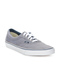
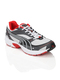
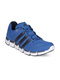


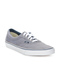
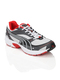
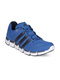

In [6]:
LIMIT = 10
YEAR = 2012

payload = {
    "gender": "Men", 
    "sub_category": "Shoes", 
    "start_year": YEAR,
    "limit": LIMIT,
}
s3_target = perform_task(payload, "filter")

# filter results
with s3.open(f'{s3_target}/metadata.json') as f:
    metadata = json.load(f)

# sample of original images
draw_images(metadata, f'{s3_target}/images')


## Task 2:

Run the same query, but now do augmentation to the images based on the given configuration

{'task_id': '2d4d6ec4-3f4d-4f68-8c6d-f7c58007aab9'}
Processing...
{'id': '2d4d6ec4-3f4d-4f68-8c6d-f7c58007aab9', 'status': 'SUCCESS', 'error': None, 'result': {'s3_target': 's3://fashion-tasks/2d4d6ec4-3f4d-4f68-8c6d-f7c58007aab9'}}
Task complete!



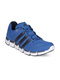
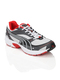
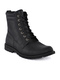
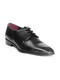
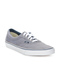
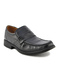
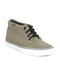
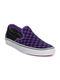
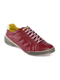
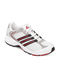


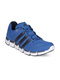
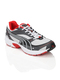
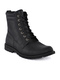
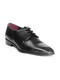
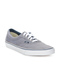
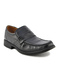
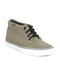
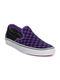
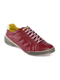
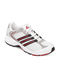


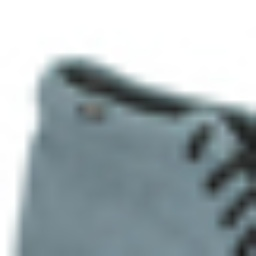
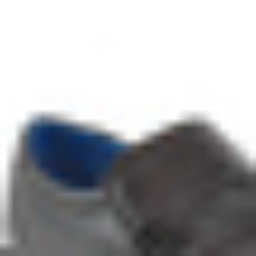
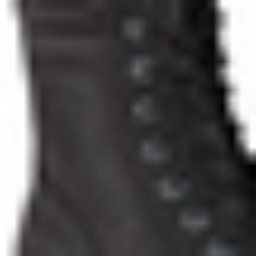
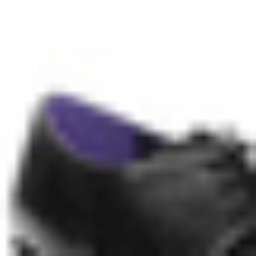
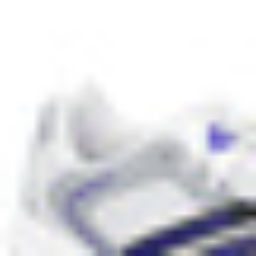
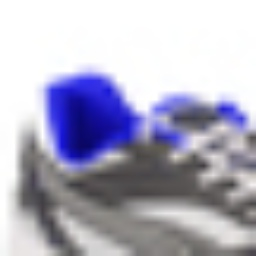
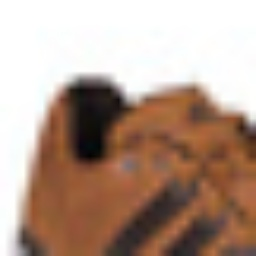
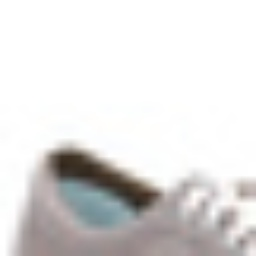
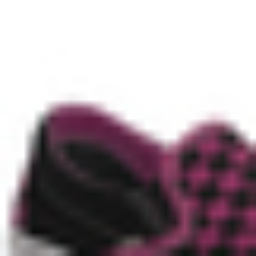
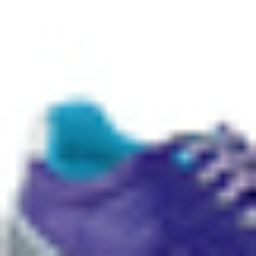


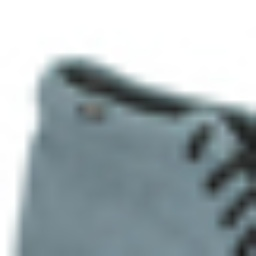
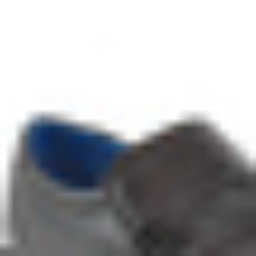
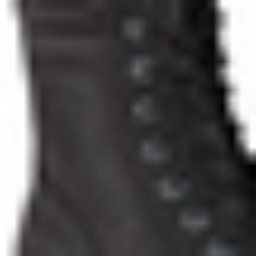
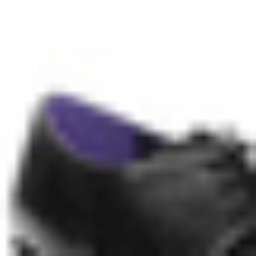
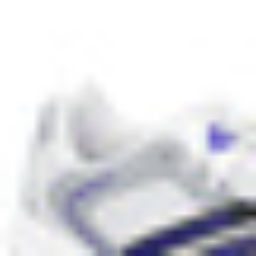
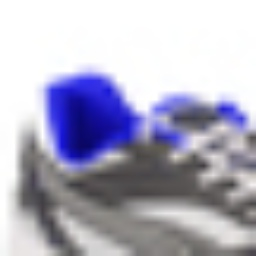
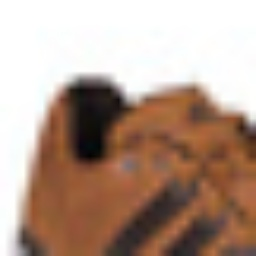
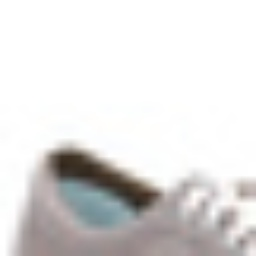
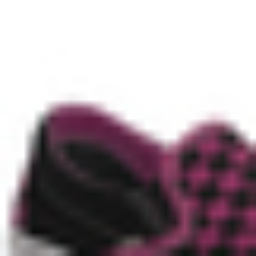
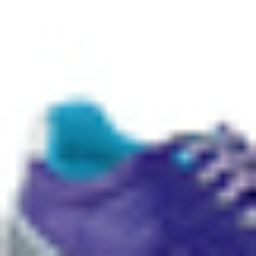

In [7]:
payload = {
    "gender": "Men", 
    "sub_category": "Shoes", 
    "start_year": YEAR,
    "limit": LIMIT,
    "augmentation_config": {'albumentation': {
        'input_image': {'width': 60, 'height': 80}, 
        'cropping': {'height': {'min': 10, 'max': 70}}, 
        'resize': {'width': 256, 'height': 256}}}
}
s3_target = perform_task(payload, "filter")

# filter results
with s3.open(f'{s3_target}/metadata.json') as f:
    metadata = json.load(f)

# sample of original images
draw_images(metadata, f'{s3_target}/images', sample=LIMIT)

# sample of transformed images
draw_images(metadata, f'{s3_target}/augmentation', sample=LIMIT)

## Task 3: 

Run inference using the FashionNetVgg16NoBn from https://github.com/i008/pytorch-deepfashion.git on the original images in Step 1 or 2.

In [12]:
s3_target = perform_task({"s3_target": s3_target}, "predict")

with s3.open(f'{s3_target}/predictions.json') as f:
    predictions = json.load(f)

print(f'Number of predictions: {len(predictions)}')
print(f'Prediction output per image: massive_attr-{len(predictions[0]["massive_attr"][0])}, categories-{len(predictions[0]["categories"][0])}')

Number of predictions: 10
Prediction output per image: massive_attr-1000, categories-50
